<a href="https://colab.research.google.com/github/dianabohorquez/spotify/blob/main/TimeSeries_ARIMA_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

La presente notebook contiene todo el desarrollo nesario para el primer TP de la materia **Análisis de Series Temporales** de la maestría en ciencia de datos de la Universidad Austral (cohorte 2020-2021).

En la [notebook A01_EDA](https://github.com/dianabohorquez/spotify/blob/main/A01_EDA_Spotify.ipynb) se hizo una breve exploración del dataset de Spotify. Se encontraron como variables de interés `danceability`, `energy` y `valence` toda vez que tienen un comportamiento no estacionario en todo la ventana de tiempo disponible en el dataset y su definición pareceriera interesante de por sí. En este data set se recuenta las observaciones destacadas de la notebook A01_EDA.

El objetivo de esta notebook es hacer pronóstico de estas variables aplicando los conceptos vistos en clase (o tal vez mejor decir aquí siguiendo la metodología de JB):

- Uno
- Dos
- Tres


---

En unos primeros párrafos colocar porque está bueno el análisis de series temporales.
En una segunda parte colocar que se va a analizar y porqué spotify. Cuál es el interés Aquí resuelvo “Buscar dos series de tiempo y exponer la problemática de interés analítico (y bla bla bla)”.
En un tercer párrafo cómo está organizado el TP, por ejemplo, de cómo son los capítulos organizados, cómo están vinculados con cada pregunta.
También aquí colocar las fuentes.
Acá la consigna, tal vez parafraseada


### Preparación del entorno

In [3]:
# manipulación de data frames y EDA
import pandas as pd
import numpy as np
from datetime import timedelta                                 # diferencia de dos fechas

# visualización
import matplotlib.pyplot as plt
import seaborn as sns

# paquetes estadísticos - modelado de series temporales
import statsmodels.api as sm                                   # modelos estadísticos
#!pip install pmdarima
import pmdarima as pm                                          # modelado automático SARIMA
from statsmodels.tsa.arima_model import ARIMA                  # modelo ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX         # modelo SARIMAX
from pylab import rcParams                                     # descomposicion de series temporales
from statsmodels.tsa.stattools import adfuller                 # test Dickey-Fuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf  # plot the (P)ACF

import warnings
warnings.filterwarnings("ignore")

In [4]:
# accessing to google
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)   #to attempt to forcibly remount  force_remount

# setting working directory
import os
os.chdir("/content/gdrive/My Drive/Data Scientist/spotify/datasets/")

Mounted at /content/gdrive


# Planteamiento del Problema

Si se refiere a datos de YouTube, Netflix o Spotify institivamente cualquiera puede responder qué producción musical o audivisual es un hit: si lleva tiempo siendo muy vista o escuchada o si rompió algún record de visitas estamos ante un producto *pop*. Para el caso de Spotify, en su [página de desarrollador](https://developer.spotify.com/documentation/web-api/reference/#endpoint-get-audio-features) ellos mencionan por ejemplo, que la `popularity` de una canción es de hecho un valor calculado por un algoritmo basado, en mayor medida, en la cantidad de reproducciones que tiene una canción. Pero, ¿cómo se puede explicar esta popularidad?

Spotify ha estructurado información no estructurada para *explicar* en términos de datos la música, definiendo variables como `loudness` (volumen general de una pista en dB), `liveness` (probabilida que el track se realizó en vivo) o `acousticness` (medida de confianza de si la pista es acústica o no). Una breve exploración de estas y otras variables se encuentran en la la [notebook A01_EDA](https://github.com/dianabohorquez/spotify/blob/main/A01_EDA_Spotify.ipynb).

De acuerdo a esa exploración, a la oportunidad de buscar analizar series de comportamiento no estacionario y a la definición que Spotify da sus variables, se preseleccionarion para este trabajo práctico `danceability`, `energy` y `valence`.

- **release_date** contiene la fecha de lanzamiento, la mayoría con formato yyyy-mm-dd.
- **energy** con un rango de 0.0 a 1.0 representa una medida perceptiva de intensidad y actividad. Por lo general, las pistas enérgicas se sienten rápidas y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características de percepción que contribuyen a este atributo incluyen rango dinámico, volumen percibido, timbre, frecuencia de inicio y entropía general.
- **valence**: con un rango de 0.0 a 1.0 `valence` describe la positividad musical que transmite una pista. Las pistas con valencia alta suenan más positivas (por ejemplo, feliz, alegre, eufórico), mientras que las pistas con valencia baja suenan más negativas (para el caso de adjetivos como triste, deprimido, enojado).

Varios datasets de Spotify están disponible en [Kaggle](https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks). Particularmente para este trabajo práctico se utilizará  `data_o.csv`, renombrado `spotify_o.csv.zip`

Es interés para este trabajo práctico pronosticar el comportamiento futuro de estas tres variables haciendo uso de análisis de series temporales.

In [7]:
# importación de datos
spotify = pd.read_csv('spotify_o.csv.zip', usecols=['release_date', 'energy', 'valence'])

# Habilitando el dataframe para trabajarlo como una serie temporal
spotify.release_date = pd.to_datetime(spotify.release_date)
spotify.set_index('release_date', inplace=True)

# Análisis Exploratorio de los Datos y Preprocesamiento

En general este data set parece limpio. No tiene valores ausentes, aparentemente sus datos son consistentes presentan muy pocos outliers y su distribución tiende a estar normalizada. Otros datos relevantes del data set son:

- La base de datos consta de 170.653 registros y 2 variables.
- No todas las canciones tienen la fecha de lanzamiento completo (algunas solo el año).
- Las observaciones van del año 1921 a 2020.
- No hay valores faltantes o nulos
- La naturaleza de los datos parece estandarizada.

In [8]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 170653 entries, 1921-01-01 to 2020-10-16
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   valence  170653 non-null  float64
 1   energy   170653 non-null  float64
dtypes: float64(2)
memory usage: 3.9 MB


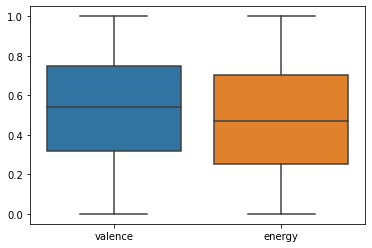

In [9]:
sns.boxplot(data=spotify);

**Tanto la variable `valence` como `energy` podría pensarse con variables con distribuciones uniformes.**

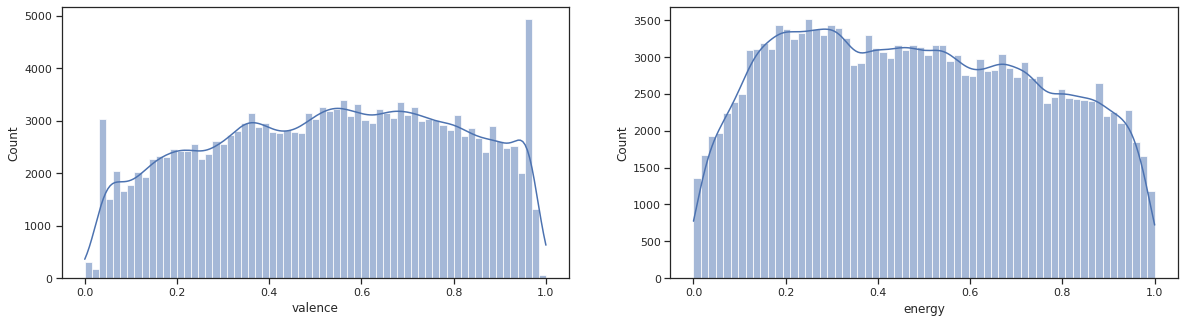

In [10]:
sns.set_theme(style="ticks")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

sns.histplot(data=spotify, x="valence", kde=True, ax=axs[0]);
sns.histplot(data=spotify, x="energy", kde=True, ax=axs[1]);

**Al graficar en un histograma (haciendo un corte entre 1975 y 1977, y 2006 y 2008) la cantidad de canciones que se lanzaron mensualmente hay un interesante patrón que muestra como en enero se hacían en promedio nueve veces más lanzamientos que en los otros meses.**

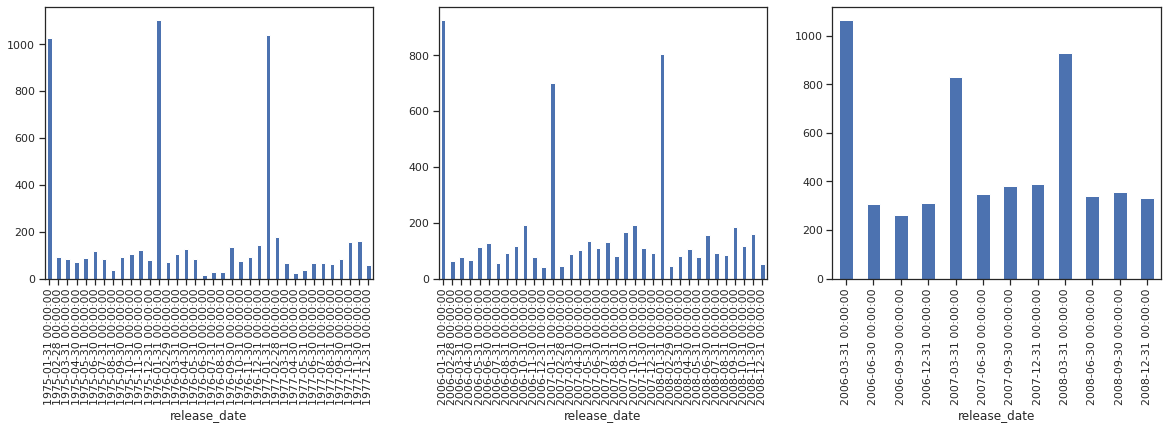

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

spotify['energy'].groupby(pd.Grouper(freq="M")).count().loc['1975':'1977'].plot(kind="bar", ax=axs[0]);
spotify['energy'].groupby(pd.Grouper(freq="M")).count().loc['2006':'2008'].plot(kind="bar", ax=axs[1]);
spotify['energy'].groupby(pd.Grouper(freq="Q")).count().loc['2006':'2008'].plot(kind="bar", ax=axs[2]);

**Por último y con el objeto de decidir la ventana temporal y la frecuencia en la que se trabajarán las series temporales se grafica cada variable promediando su valor anual.**

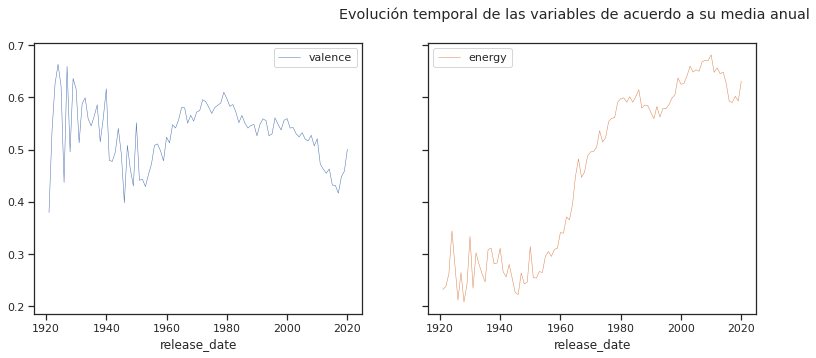

In [12]:
spotify.groupby(spotify.index.year).mean().plot(subplots=True
                                                , linewidth=0.5
                                                , layout=(1,3)
                                                , figsize=(20, 5)
                                                , sharex=False
                                                , sharey=True
                                                , title = 'Evolución temporal de las variables de acuerdo a su media anual');

En resumen, algunas de las características observadas en este apartado exploratorio son:

- Con periodicidad anual las señales se suavisan siendo menos ruidosas.
- Con el pasar de los años los valores tienen menos variabilidad.
- Cerca y después del año 1960 la información parece menos errática.
- Visualmente se puede decir que ningunas de las dos series es estacionaria.
- Hay una aparente estacionalidad presente anualmente en los meses de enero. Esta variación periódica podría también representarse trimestralmente.

Considerando todas estas observaciones se define como dataset de interés los datos a partir de 1960 y agrupados trimestralmente.

In [13]:
# Eliminado los datos menores a 1960 (inclusive) y agrupándolos según su promedio trimestral
spotify = spotify.groupby(pd.Grouper(freq="Q")).mean()
spotify = spotify.iloc[160:,]

# Marco Teórico

El objetivo de este TP es pronosticar el comportamiento de tres variables que definen características del audio de  algunas de las canciones disponibles en Spotify.

## Propiedades de las series temporales

*Graficar las series originales. Analizar si es necesario diferenciarlas para convertirlas en estacionarias. Exponer los conceptos relacionados con la estacionariedad de la serie. Utilizar como criterio un test de raíces unitarias que consideren pertinente.*

Visualmente ninguna de las series parece estacionaria. Al descomponer las series pueden visualizarse uno a uno las propiedades de las series temporales.

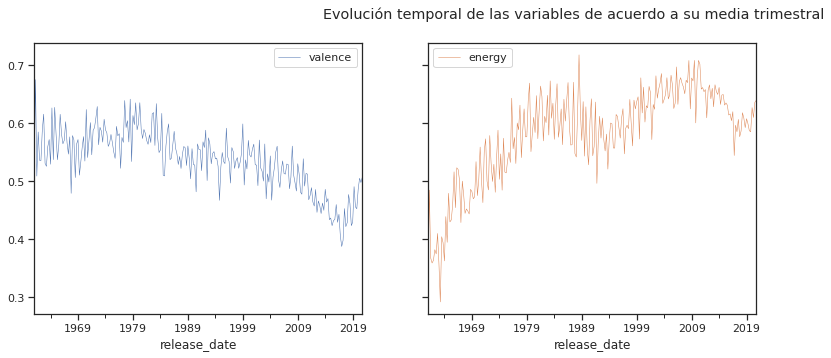

In [15]:
spotify.plot(subplots=True
                    , linewidth=0.5
                    , layout=(1, 3)
                    , figsize=(20, 5)
                    , sharex=False
                    , sharey=True
                    , title = 'Evolución temporal de las variables de acuerdo a su media trimestral');

### Tendencia

### Estacionalidad

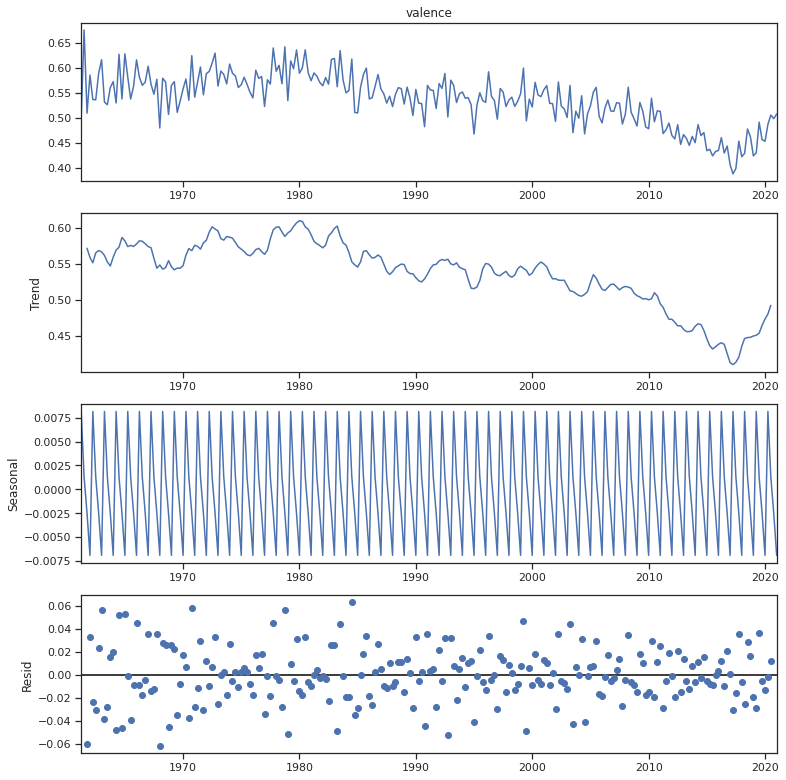

In [16]:
# Descomposicion de la serie temporal Valence
rcParams['figure.figsize'] = 11, 11
decomposeValence = sm.tsa.seasonal_decompose(spotify['valence'])
fig = decomposeValence.plot();

### Ruido

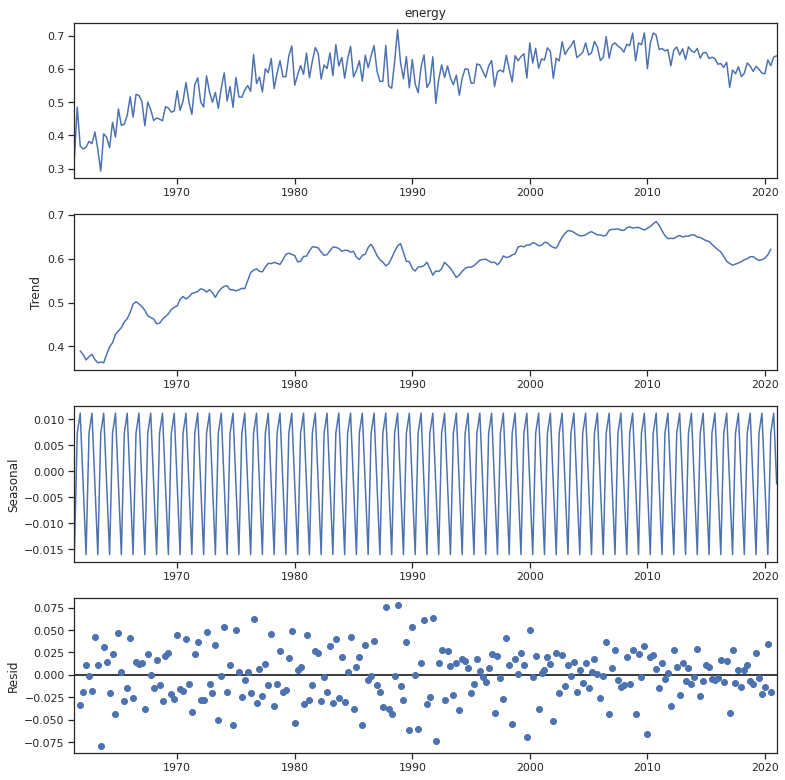

In [17]:
# Descomposicion de la serie temporal Energy
rcParams['figure.figsize'] = 11, 11
decomposeValence = sm.tsa.seasonal_decompose(spotify['energy'])
fig = decomposeValence.plot();

### Test de raíces unitarias

Para testear si una serie sigue un proceso de random walk, se puede hacer una regresion de los precios actuales en los precios con retardo (*)

$P_{t} = \alpha + \beta P_{t-1} + \epsilon_{t}$


**Test:**

$H_{0}: \beta = 1$ (random walk) -> it means the time series has a unit root an that means that if we graph of the time series it is NOT STATIONARY

$H_{1}: \beta < 1$ (not random walk) - time series would be stationary


---
.

(*) equivalente a, o, en otra forma de hacer este testeo es hacer la regresión sobre las diferencias de los precios.

$P_{t} - P_{t-1} = \alpha + \beta P_{t-1} + \epsilon_{t}$

.

**Test:**

$H_{0}: \beta = 0$ (random walk)

$H_{1}: \beta < 0$ (not random walk)

.

Este test se llama **Dickey-Fuller**; si se suman más retardos en el lado izquierdo de la ecuacción el test se llamaría **Augmented Dickey-Fuller test**.

- 0th element is test statistic (-1.34)
    - More negative means more likely to be stationary
- 1st element is p-value: (0.60)
    - If p-value is smaller than 0.05 → reject null hypothesis and assume our time series must be stationary. Reject non-stationary.
- 4th element is the critical test statistics

[statsmodels - adfuller](hps://www.statsmodels.org/dev/generated/statsmodels.tsa.staools.adfuller.html)

In [18]:
v_adfuller = adfuller(spotify['valence'])
print('p-value test adfuller quarter valence: ', v_adfuller[1], '-> entonces no rechazamos H0, por lo tanto la serie es un random walk')

e_adfuller = adfuller(spotify['energy'])
print('p-value test adfuller quarter energy: ', e_adfuller[1], '-> entonces rechazamos H0, por lo tanto la serie no es un random walk, entonces la serie es estacionaria')

#p-value es mayor que 0.05 entonces no podemos rechazar la H0, con lo cual no podemos asumir estacionariedad.

p-value test adfuller quarter valence:  0.3980382475045702 -> entonces no rechazamos H0, por lo tanto la serie es un random walk
p-value test adfuller quarter energy:  0.017150791572558437 -> entonces rechazamos H0, por lo tanto la serie no es un random walk, entonces la serie es estacionaria


Since the temperature series, `temp_NY`, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

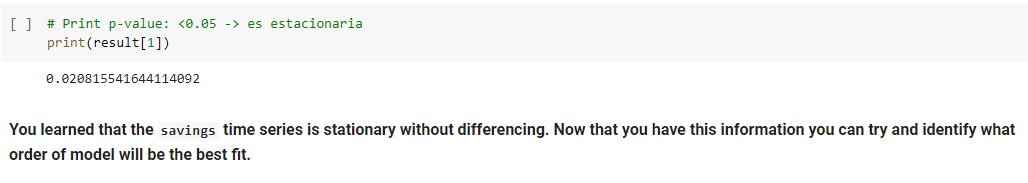

## 2. Función de Autocorrelación

*Graficar la FAS, FAC y FACP de las mismas en un solo gráfico y analizarlas. ¿Qué puede inferir de los gráficos?. Justificar con teoría.*

¿Qué es la autocorrelación? Es la correlación de una serie temporal con sigo misma, pero considerando los retardos. Esto es, la correlación de la serie con la misma serie con un retardo de $n$ periodos.

Interpretación de la autocorrelación

- Mean Reversion (reversión a la media): autocorrelación negativa (gráficamente se ve ondulado)
- Momentun or Trend Following: autocorrelación positiva (es una montaña)

Contrario a la autocorrelación, la **autocorrelación parcial** remueve los efectos de los tiempos anteriores (?)

In [19]:
cambios = spotify.diff().dropna()
v_autocorrelacion = cambios['valence'].autocorr()
print("La autocorrelación del ratio de cambio de la valencia trimestral es %4.2f" %(v_autocorrelacion))
e_autocorrelacion = cambios['energy'].autocorr()
print("La autocorrelación del ratio de cambio de la energía trimestral es %4.2f" %(e_autocorrelacion))

La autocorrelación del ratio de cambio de la valencia trimestral es -0.56
La autocorrelación del ratio de cambio de la energía trimestral es -0.50


In [ ]:
cambiosA = spotifyAnual.diff().dropna()
autocorrelacionAV = cambiosA['valence'].autocorr()
print("La autocorrelación del ratio de cambio de la valencia trimestral es %4.2f" %(autocorrelacionAV))
autocorrelacionAD = cambiosA['danceability'].autocorr()
print("La autocorrelación del ratio de cambio de la bailabilidad trimestral es %4.2f" %(autocorrelacionAD))
autocorrelacionAE = cambiosA['energy'].autocorr()
print("La autocorrelación del ratio de cambio de la energía trimestral es %4.2f" %(autocorrelacionAE))

La autocorrelación del rato de cambio de la valencia trimestral es -0.13
La autocorrelación del rato de cambio de la bailabilidad trimestral es -0.45
La autocorrelación del rato de cambio de la energía trimestral es -0.06


When you look at daily changes in interest rates, the autocorrelation is close to zero. *However*, if you resample the data and look at annual changes, the autocorrelation is negative. **This implies that while short term changes in interest rates may be uncorrelated, long term changes in interest rates are negatively autocorrelated**. A daily move up or down in interest rates is unlikely to tell you anything about interest rates tomorrow, but a move in interest rates over a year can tell you something about where interest rates are going over the next year. 

In [ ]:
acf(spotifyAnual['valence'])

array([ 1.        ,  0.91677295,  0.84558325,  0.76390623,  0.67774441,
        0.57915963,  0.51941158,  0.43834847,  0.37271551,  0.29083512,
        0.23743283,  0.19567287,  0.15566105,  0.13411507,  0.10997344,
        0.06088078,  0.03254661,  0.0241376 , -0.00594913, -0.01139394,
       -0.01198252, -0.01531648, -0.0258856 , -0.02791327, -0.05264221,
       -0.05636898, -0.07234775, -0.08283312, -0.10510622, -0.1327102 ,
       -0.17495986, -0.21058321, -0.25722845, -0.28962675, -0.31703184,
       -0.34980412, -0.36923354, -0.38204578, -0.39004006, -0.38636114,
       -0.36144125])

**La función de autocorrelación (ACF)** es una función de los retardos (no solo del último lag, sino de diferentes retardos). Algunos de sus usos son:

- Cualquier autocorrelación (estadísticamente) significante implica que la serie puede ser pronosticada considerando su pasado
    - En la PPT muestra una función de ACF en donde hay dos lags distintos de cero. Esto significa, para ese caso particular, que se pueden usar los últimos dos valores para predecir el presente
- Se observan también comportamientos estacionales
- Para seleccionar un modelo

Since the temperature series, `temp_NY`, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

**Making a time series stationary**

- Taking the difference: $\Delta y_{t} = y_{t}-y_{t-1}$
- Taking the log → `np.log(df)`
- Taking the square root → `np.sqrt(df)`
- Taking the proportional change → `df.shift(1)/df`

In [21]:
# Seasonal adjust quarterly
spotifySeasonalAdjust = spotify.diff().dropna()

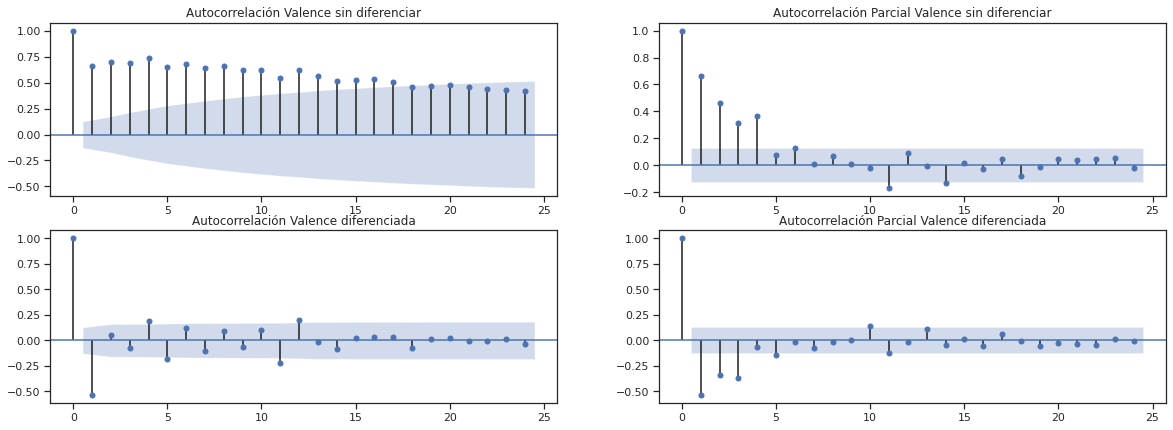

In [22]:
# Gráfica ACF y PACF de valence con la serie original y diferenciada
fig, axes = plt.subplots(2,2, figsize=(20, 7))
plot_acf(spotify['valence'], ax=axes[0, 0], title='Autocorrelación Valence sin diferenciar');
plot_pacf(spotify['valence'], ax=axes[0, 1], title='Autocorrelación Parcial Valence sin diferenciar');
plot_acf(spotifySeasonalAdjust['valence'], ax=axes[1, 0], title='Autocorrelación Valence diferenciada');
plot_pacf(spotifySeasonalAdjust['valence'], ax=axes[1, 1], title='Autocorrelación Parcial Valence diferenciada');

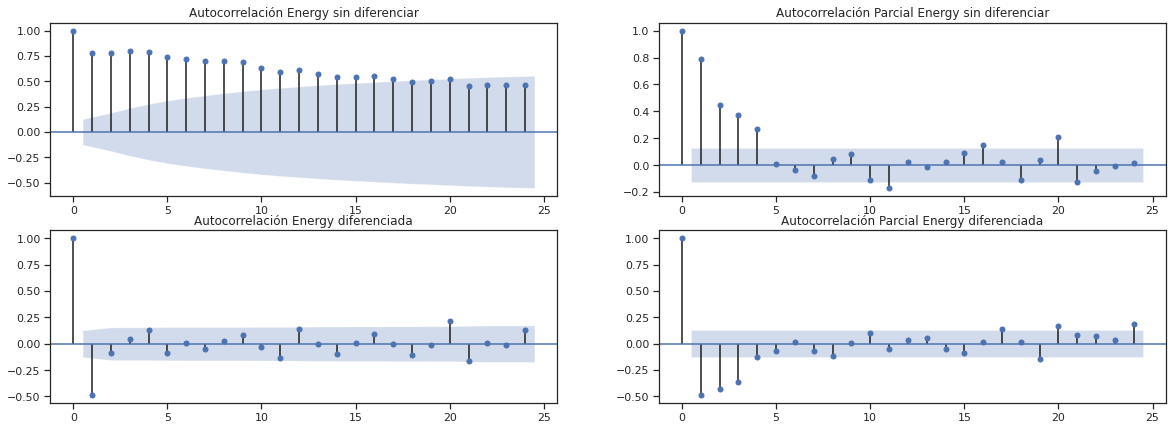

In [23]:
# Gráfica ACF y PACF de energy con la serie original y diferenciada
fig, axes = plt.subplots(2,2, figsize=(20, 7))
plot_acf(spotify['energy'], ax=axes[0, 0], title='Autocorrelación Energy sin diferenciar');
plot_pacf(spotify['energy'], ax=axes[0, 1], title='Autocorrelación Parcial Energy sin diferenciar');
plot_acf(spotifySeasonalAdjust['energy'], ax=axes[1, 0], title='Autocorrelación Energy diferenciada');
plot_pacf(spotifySeasonalAdjust['energy'], ax=axes[1, 1], title='Autocorrelación Parcial Energy diferenciada');

In [24]:
#adfS = adfuller(spotifySeasonalAdjust['danceability'].diff().dropna())
#print('ADF Statistic:', adfS[0])
#print('p-value:', adfS[1])
#spotifySeasonalAdjust = spotifyQuarter.diff().dropna()

sav_adfuller = adfuller(spotifySeasonalAdjust['valence'])
print('p-value test adfuller quarter valence: ', sav_adfuller[1], '-> entonces no rechazamos H0, por lo tanto la serie es un random walk')

sae_adfuller = adfuller(spotifySeasonalAdjust['energy'])
print('p-value test adfuller quarter energy: ', sae_adfuller[1], '-> entonces no rechazamos H0, por lo tanto la serie es un random walk')

p-value test adfuller quarter valence:  2.9421281845410765e-30 -> entonces no rechazamos H0, por lo tanto la serie es un random walk
p-value test adfuller quarter energy:  1.1011008283258128e-24 -> entonces no rechazamos H0, por lo tanto la serie es un random walk


## Modelado -> variable Energía


**Para comenzar separamos en train y test**

In [25]:
# Split los datos en entrenamiento y test
spotify_train = spotify.loc[:'2002']
spotify_test = spotify.loc['2003':]

# Index de las fechas de test
dates_test = spotify_test.index

### Estimando el orden del modelo

*Efectuar una estimación de la serie temporal con distintos órdenes de parámetros de modelos (S)ARIMA y encontrar aquel que se ajuste mejor a los datos (pueden emplear Criterios de Información y analizar significatividad individual y global de los parámetros del modelo).*

In [26]:
# Estimando el mejor modelo ARIMA para energy
order_energy =[]
# Loop sobre orden de AR
for p in range(5):
    # Loop sobre orden de Integración
    for d in range(5):
        # Loop sobre orden de MA
        for q in range (5):
            try:
                # Ajuste del modelo modelo
                model = SARIMAX(spotify_train['energy'], order=(p,d,q))
                results = model.fit()
                # impresión del orden del modelo con valores AIC/BIC
                #print(p, d, q, results.aic, results.bic)
                # Sumar orden y resultados a la lista
                order_energy.append((p, d, q, results.aic, results.bic))
            except:
                # Impresión de AIC y BIC como None cuando el modelo falla
                print(p, d, q, None, None)
 
# Creación de dataframe con los órdenes del modelo y los resultados de AIC/BIC
order_df_energy = pd.DataFrame(order_energy, columns=['p', 'd', 'q', 'aic', 'bic'])

### Selección del Modelo

In [27]:
e_autoarima = pm.auto_arima(spotify_train['energy'], seasonal=True)
e_autoarima

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [28]:
order_df_energy.sort_values('bic').head(5)

,p,d,q,aic,bic
8,0,1,3,-583.934053,-571.462077
56,2,1,1,-583.459311,-570.987336
7,0,1,2,-580.147312,-570.793331
6,0,1,1,-576.187976,-569.951989
32,1,1,2,-581.582647,-569.110672


In [29]:
order_df_energy.sort_values('aic').head(5)

,p,d,q,aic,bic
109,4,1,4,-584.427530,-556.365586
8,0,1,3,-583.934053,-571.462077
81,3,1,1,-583.548711,-567.958742
56,2,1,1,-583.459311,-570.987336
57,2,1,2,-583.078310,-567.488341


In [30]:
# Modelo ARIMA para energy
arima_energy = SARIMAX(spotify_train['energy'], order=(2,1,1))
arima_energy_results = arima_energy.fit()
print(arima_energy_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 energy   No. Observations:                  168
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 295.730
Date:                Fri, 30 Jul 2021   AIC                           -583.459
Time:                        14:01:13   BIC                           -570.987
Sample:                    03-31-1961   HQIC                          -578.397
                         - 12-31-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3106      0.115     -2.702      0.007      -0.536      -0.085
ar.L2         -0.2771      0.104     -2.659      0.008      -0.481      -0.073
ma.L1         -0.6111      0.092     -6.650      0.0

### Análisis de Diagnóstico

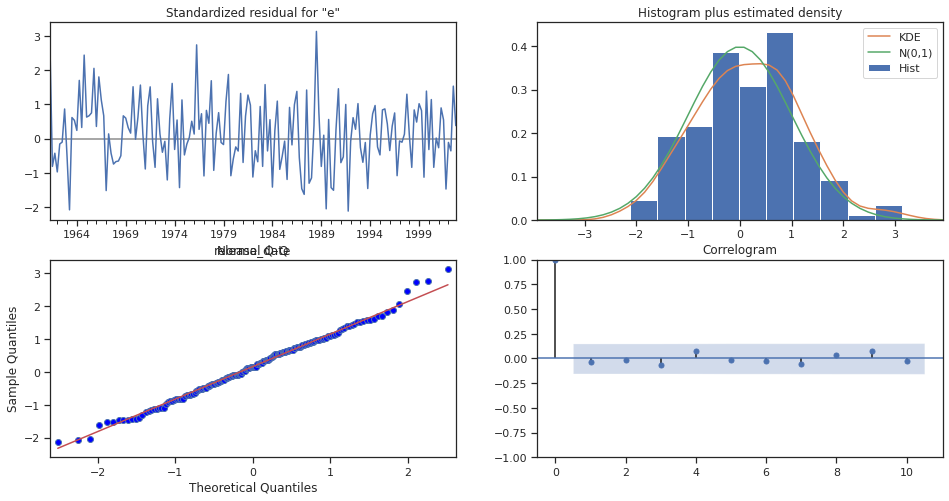

In [31]:
arima_energy_results.plot_diagnostics(figsize=(16,8));

### Pronóstico con el modelo

In [32]:
# Pronóstico con modelo entrenado con trainind data
# Crear objeto forecast
e_forecast = arima_energy_results.get_forecast(steps=72)   # 72 pasos hay en test

# Extraer el atributo predicted mean
e_meanForecast = e_forecast.predicted_mean
# otra forma de tener e_meanForecast:
# e_predictions = arima_energy_results.predict(start=spotify_test['energy'].index[0], end=spotify_test['energy'].index[-1])
e_residuals = spotify_test['energy'] - e_meanForecast

# Calcular los intervalos de confianza
e_conf_int = e_forecast.conf_int()

# Extract the forecast dates
#datesQE_tt = meanQE_tt.index

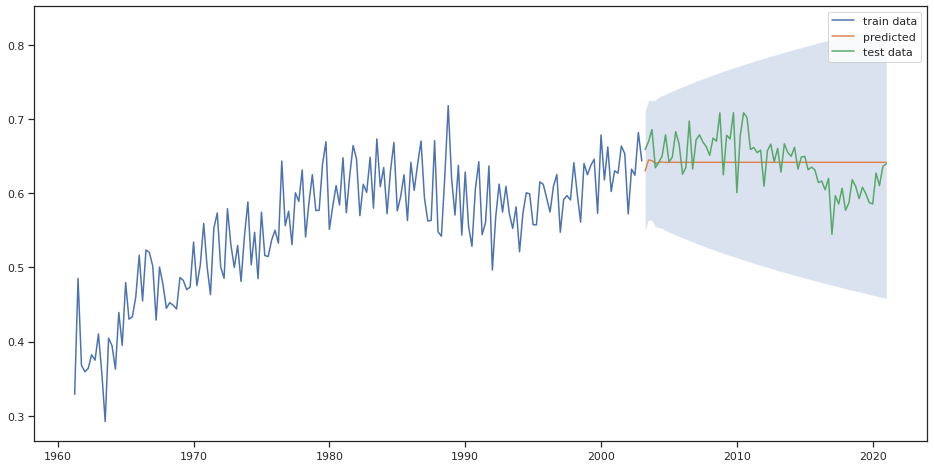

In [33]:
# Graficar datos de entrenamiento, test, y pronóstico
# Plot past
plt.figure(figsize=(16, 8))
plt.plot(spotify_train.index, spotify_train['energy'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, e_meanForecast, label='predicted');
plt.plot(spotify_test['energy'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, e_conf_int['lower energy'], e_conf_int['upper energy'], alpha=0.2);

# Plot legend and show figure
plt.legend();

In [34]:
# Estamos 4% lejos del promedio
print('Mean Absolute Percent Error:', round(np.mean(abs(e_residuals/spotify_test['energy'])),4))

Mean Absolute Percent Error: 0.044


In [35]:
# 0.03 unidades de escala fuera en promedio
print('Root Mean Squared Error:', np.sqrt(np.mean(e_residuals**2)))

Root Mean Squared Error: 0.03421481858971006


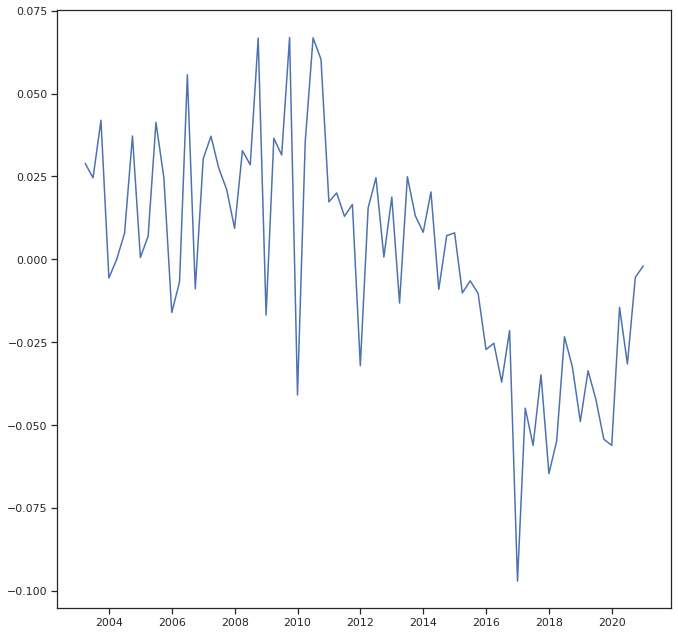

In [36]:
# si hay un pattern en los residuos hay un conmportamiento dinámicno que no se está capturando.
# típicamente se vería como una onda, o como que decrece (un comportamiento lineal)
# creo que en mi caso se ve bastante bien los residuos. Erráticos
plt.plot(e_residuals);

**Rolling Forecast Origin**

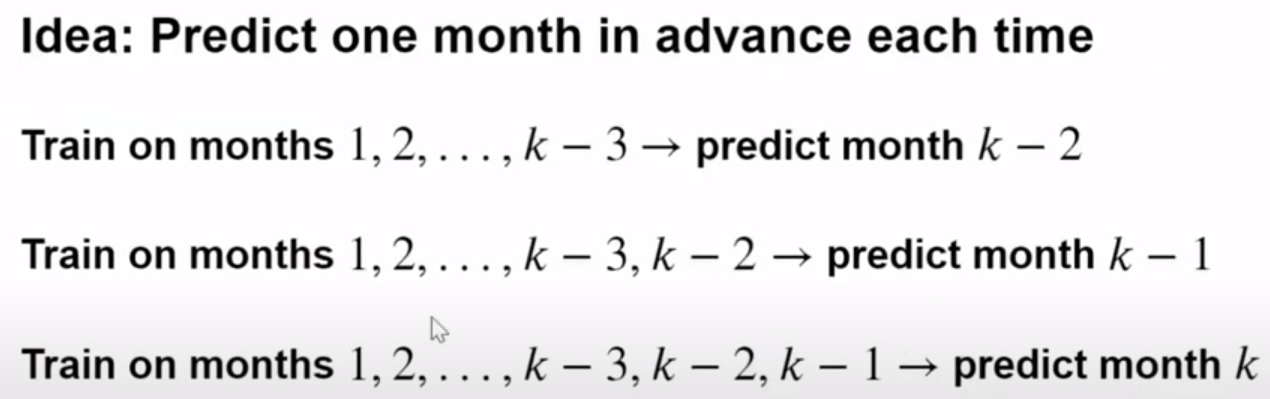


Predice solo un trimestre a la vez

In [37]:
# create the model
predictions_rolling = pd.Series()
for end_date in spotify_test['energy'].index:
    train_data = spotify['energy'][pd.to_datetime('1961-03-31'):][:end_date - timedelta(days=1)]
    model = SARIMAX(train_data, order=(4, 1, 4))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date] = pred.loc[end_date]


In [38]:
residuals_rolling = spotify_test['energy'] - predictions_rolling

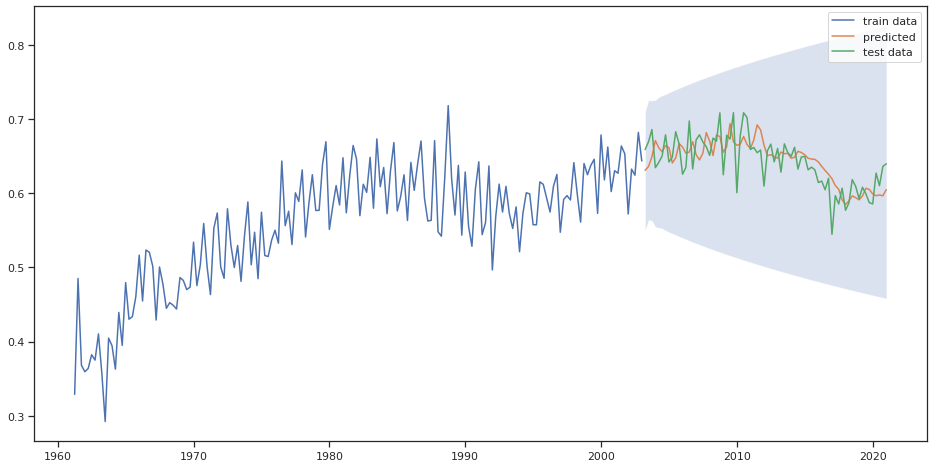

In [39]:
# Graficar datos de entrenamiento, test, con rolling forecast
# Plot past
plt.figure(figsize=(16, 8))
plt.plot(spotify_train.index, spotify_train['energy'], label='train data');

# Graficar la predicción como una línea
plt.plot(dates_test, predictions_rolling, label='predicted');
plt.plot(spotify_test['energy'], label='test data')

# Sombra en los intervalos de confianza
plt.fill_between(dates_test, e_conf_int['lower energy'], e_conf_int['upper energy'], alpha=0.2);

# Plot legend and show figure
plt.legend();

la contra de esto es que cada periodo tengo que volver a entrenar el modelo. Tipicamente es OK en serie temporales.

In [40]:
# Bajó un 1% lejos del promedio
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals_rolling/spotify_test['energy'])),4))

# 0.02 unidades de escala fuera en promedio
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.0329
Root Mean Squared Error: 0.025623177096586347


**Si queremos hacer predicciones en otra ventana de tiempo**

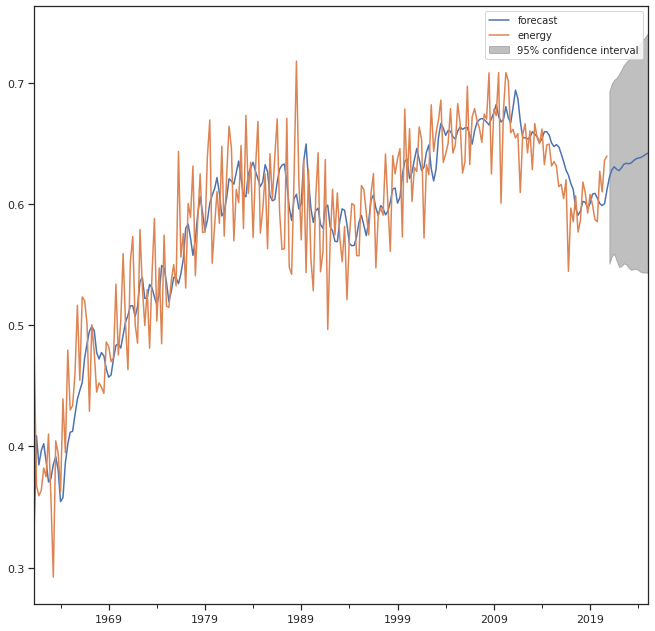

In [41]:
e_mod_arima = ARIMA(spotify['energy'], order=(4, 1, 4))
e_res_arima = e_mod_arima.fit()
e_res_arima.plot_predict(start='1961', end='2025');
plt.legend(fontsize=10);

## Modelado -> variable Valence

### Estimando el orden del modelo

In [42]:
# Estimando el mejor modelo ARIMA para valence
order_valence =[]
# Loop sobre orden de AR
for p in range(4):
    # Loop sobre orden de Integración
    for d in range(2):
        # Loop sobre orden de MA
        for q in range (2):
            try:
                # Ajuste del modelo modelo
                model = SARIMAX(spotify_train['valence'], order=(p,d,q))
                results = model.fit()
                # impresión del orden del modelo con valores AIC/BIC
                #print(p, d, q, results.aic, results.bic)
                # Sumar orden y resultados a la lista
                order_valence.append((p, d, q, results.aic, results.bic))
            except:
                # Impresión de AIC y BIC como None cuando el modelo falla
                print(p, d, q, None, None)
 
# Creación de dataframe con los órdenes del modelo y los resultados de AIC/BIC
order_df_valence = pd.DataFrame(order_valence, columns=['p', 'd', 'q', 'aic', 'bic'])

### Selección del Modelo

In [43]:
v_autoarima = pm.auto_arima(spotify_train['valence'], seasonal=True)
v_autoarima

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [44]:
order_df_valence.sort_values('bic').head(5)

,p,d,q,aic,bic
7,1,1,1,-667.833118,-658.479136
3,0,1,1,-664.181690,-657.945702
11,2,1,1,-665.988986,-653.517011
5,1,0,1,-660.547549,-651.175657
9,2,0,1,-662.510735,-650.014879


In [45]:
order_df_valence.sort_values('aic').head(5)

,p,d,q,aic,bic
7,1,1,1,-667.833118,-658.479136
11,2,1,1,-665.988986,-653.517011
15,3,1,1,-665.280921,-649.690952
3,0,1,1,-664.181690,-657.945702
9,2,0,1,-662.510735,-650.014879


In [46]:
# Modelo ARIMA para valence
arima_valence = SARIMAX(spotify_train['valence'], order=(1,1,1))
arima_valence_results = arima_valence.fit()
print(arima_valence_results.summary())

                               SARIMAX Results                                
Dep. Variable:                valence   No. Observations:                  168
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 336.917
Date:                Fri, 30 Jul 2021   AIC                           -667.833
Time:                        14:15:10   BIC                           -658.479
Sample:                    03-31-1961   HQIC                          -664.037
                         - 12-31-2002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2153      0.087     -2.463      0.014      -0.387      -0.044
ma.L1         -0.8330      0.061    -13.668      0.000      -0.952      -0.714
sigma2         0.0010   9.98e-05     10.274      0.0

**si la ecuación del modelo fuera** $y_{t}=-0.2y_{t-1}+0.3_{\epsilon_{t-1}}+0.4{\epsilon_{t-2}}+{\epsilon_{t}}$ estos serían los parámetros. Don't forget to set the lag-0 coefficients to 1.
```
# Set coefficients
ar_coefs = [1, 0.2]
ma_coefs = [1, 0.3, 0.4]
```


### Análisis de Diagnóstico

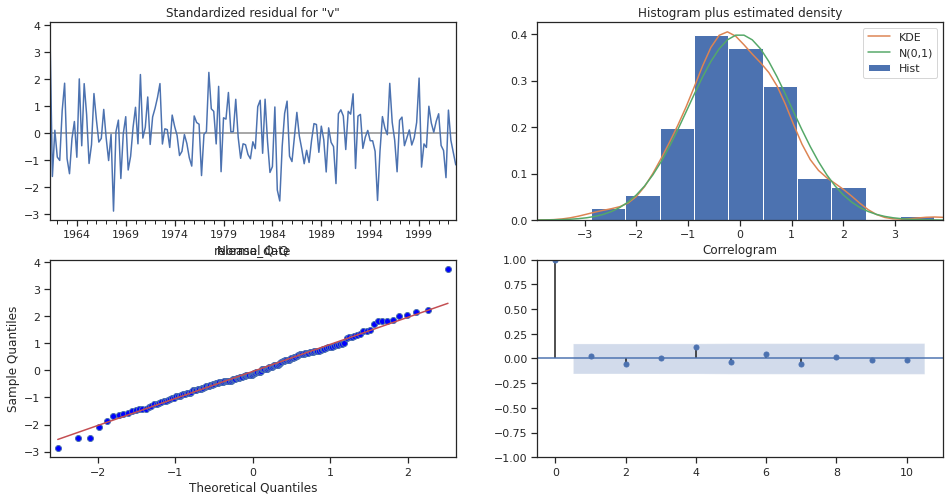

In [47]:
arima_valence_results.plot_diagnostics(figsize=(16,8));

### Pronósticos con el modelo

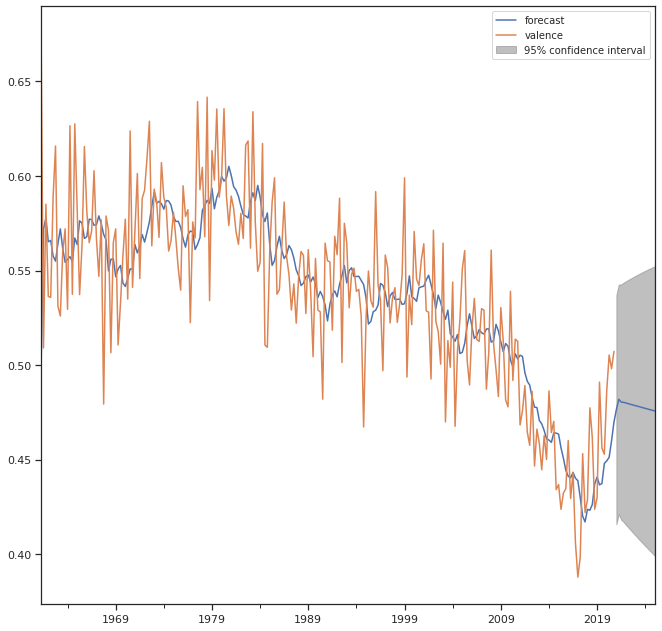

In [48]:
v_mod_arima = ARIMA(spotify['valence'], order=(1, 1, 1))
v_res_arima = v_mod_arima.fit()
v_res_arima.plot_predict(start='1961', end='2025');
plt.legend(fontsize=10);

# Análisis de Resultados

# Conclusiones